In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy
import math

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old
import allantools
from IPython.display import clear_output
from analysis_helper import root_to_pandas

Welcome to JupyROOT 6.12/04


In [3]:
def plt_unix_time_to_CST(ax):
    ax.locator_params(axis='x', nbins=5)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                        for tm in xticks], rotation=0, fontdict={'size':10, 'family':'serif'})

def difference(y, avgt):      ##Compresses an array by averaging over the given averaging time to "bin" the data, difference is a misleading name
    t = np.arange(int(avgt) , len(y), int(avgt))
    N = len(t)
    Sum = 0
    avgdiff = np.array([])
    for i in range(len(y)):
        Sum += y[i]
        if i % avgt == 0 and i > 0:
            avg = Sum/avgt
            Sum = 0
            avgdiff = np.append(avgdiff, avg)
            
        
    return (t,avgdiff)

def MovingAvg(x, bin_size):
    i = 0
    avg = np.array([])
    while (i <= len(x) - bin_size):
        Sum = 0
        j = 0
        while (j < bin_size):
            Sum += x[i + j]
            j += 1
        avg = np.append(avg, Sum/bin_size)
        if(i % 86400 == 0):
            print(str(i) + "iterations done")
        i +=1
    return avg
        
def line(x,m,b): #just a line equation
    return m*x + b

def Multiplot(x_data, y_data, height, width, dimension, sublabels = None, x_axis_labels = None, y_axis_labels = None, figname = None, CST = False, daylines = False, day_offset = 0, logscale = False, day_label = ""):
    #x_data is an array containing arrays with the different data to plot
    #y_data ""
    #width is the width of the whole figure in inches
    #height is the height of the whole figure in inches
    #dimension is an array containing the dimensions of the plot figure np.array([3,2])  would correspond to 6 plots (3 rows, 2 cols)
    #x_axis_labels labels is an array containing the labels on the subplots
    #Similarly for y
    #sublabels are the titles are the subplots (1 x n array of strings), can just be 1 x 1 if all the same
    #Figname is the name of the plot
    #CST will convert the x-axis data into CST time
    #Daylines will plot red lines to show days.
    #day_offset in case we want the 24 hour mark to be somewhere else other than just 24 hours from the start
    for i in range(len(x_data)):
        if len(x_data[i]) != len(y_data[i]):
            print("The dimensions of x[" + str(i) + "] and y[" + str(i) + "] do not match")
    
    equal_x_labels = True
    for k in range(len(x_axis_labels)):
        for l in range(len(x_axis_labels)):
            if k != l:
                if  x_axis_labels[k] != x_axis_labels:
                    equal_x_labels = False
                    
    equal_y_labels = True
    for k in range(len(y_axis_labels)):
        for l in range(len(y_axis_labels)):
            if k != l:
                if  y_axis_labels[k] != y_axis_labels:
                    equal_y_labels = False
    day = np.array([86400,86400])
    fig, axs = plt.subplots(dimension[0], dimension[1], constrained_layout=True)
    fig.set_figheight(height)
    fig.set_figwidth(width)
    for i in range(dimension[0]):
        for j in range(dimension[1]):
            axs[i,j].plot(x_data[dimension[1] * i + j], y_data[dimension[1] * i + j])
            if equal_x_labels:
                axs[i,j].set_xlabel(x_axis_labels[0])
            else:
                axs[i,j].set_xlabel(x_axis_labels[dimension[1] * i + j])
            if equal_y_labels:
                axs[i,j].set_ylabel(y_axis_labels[0])
            else:
                axs[i,j].set_ylabel(y_axis_labels[dimension[1] * i + j])
            axs[i,j].set_title(sublabels[dimension[1] * i + j])
            if daylines:
                days = int((x_data[dimension[1] * i + j].max() - x_data[dimension[1] * i + j].min()) / 86400)
                for n in range(days):
                    axs[i,j].plot(day * (n+1) + day_offset + x_data[dimension[1] * i + j][0], [y_data[dimension[1] * i + j].min(), y_data[dimension[1] * i + j].max()], 'r', label = day_label)
                    axs[i,j].legend()
            if logscale:
                axs[i,j].set_xscale('log')
                axs[i,j].set_yscale('log')
            if CST:
                plt_unix_time_to_CST(axs[i,j])
    fig.suptitle(figname)

def ArrayRound(array, value):
    #For a 1-D array of values that are non-decreasing everywhere. Returns the element of the array closest to the value given
    inf = -1
    sup = -1
    if array[0] >= value:
        return array[0]
    else:
        for number in array:
            if number <= value:
                inf = number
        if inf == value:
            return value
        else:
            sup = array[np.where(array == inf)[0] +1]
            if abs(inf - value) < abs(sup - value):
                return inf
            elif abs(inf-value) > abs(sup - value):
                return sup
            else:
                print("The closest the value provided is exactly in between two elements of the array, the lower element has been returned.")
                return inf
        
    
def DayLineFit(time_data, y_data, start):
    #Fits lines on points 24 hours apart. Assuming the time data is in seconds, takes into account any binning done
    #Assumes time_data points are equally spaced; hence the the difference variable
    step = ArrayRound(time_data, start)
    difference = time_data[1] - time_data[0]
    day = int(round(86400/difference,0))
    slopes = np.array([])
    intercepts = np.array([])
    test = np.array([step, step + (day*difference)])
    while step + 86400 <= time_data[-1]:
        x = np.array([step, step + (day*difference)])
        y = np.array([y_data[np.where(time_data == step)[0]], y_data[np.where(time_data == step + (day*difference))[0]]])
        z = np.polyfit(x,y,1)
        slopes = np.append(slopes, z[0])
        intercepts = np.append(intercepts, z[1])
        step = time_data[np.where(time_data == step)[0][0] +1]
    return slopes, intercepts

def DayParFit(time_data, y_data, start):
    #Fits parabola on points 24 hours apart. Assuming the time data is in seconds, takes into account any binning done
    #Assumes time_data points are equally spaced; hence the the difference variable
    step = ArrayRound(time_data, start)
    difference = time_data[1] - time_data[0]
    day = int(round(86400/difference,0))
    a = np.array([])
    b = np.array([])
    c = np.array([])
    while step + 2*86400 <= time_data[-1]:
        x = np.array([step, step + (day*difference), step + (2*(day*difference))])
        y = np.array([y_data[np.where(time_data == step)[0]], y_data[np.where(time_data == step + (day*difference))[0]], y_data[np.where(time_data == step + (2*(day*difference)))[0]]])
        z = np.polyfit(x,y,2)
        a = np.append(a, z[0])
        b = np.append(b, z[1])
        c = np.append(c, z[2])
        step = time_data[np.where(time_data == step)[0][0] +1]
    return a, b, c

def LogSlope(x,y,a): #Returns the slope of a graph at x = a, a is the actual number, not log of the point of interest.
    figwidth = 13
    figheight = 5
    a = ArrayRound(x,a)
    t = np.where(x == a)[0][0]
    diff_y32 = np.log10(y[t + 1]) - np.log10(y[t])
    diff_x32 = np.log10(x[t + 1]) - np.log10(x[t])
    diff_y21 = np.log10(y[t]) - np.log10(y[t-1])
    diff_x21 = np.log10(x[t]) - np.log10(x[t-1])
    m = (.5*(diff_y32/diff_x32)) + (.5*(diff_y21/diff_x21))
    b = np.log10(y[t]) - m * np.log10(x[t])
    line = (10** b) * (x ** m)
    
    fig, axs = plt.subplots(1, 1, constrained_layout=True)
    fig.set_figheight(figheight)
    fig.set_figwidth(figwidth)
    axs.plot(x,y)
    axs.plot(x, line, label = "y = " + str(np.round(m,2)) + "x + " + str(np.round(b, 2)))
    axs.plot([x[t]], [y[t]],'o', 'k')
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.legend()
    axs.set_ylim(min(y), max(y))
    axs.set_aspect('equal')
    plt.show()
    
def cos(x, A, phi):
    period = 86400
    return A * np.cos(2 * np.pi * x / period  + phi)

def ResSquare(obs, exp):
    s = 0
    if(len(obs)!= len(exp)):
        print("The length of the arrays in the ResSquare function are not equal")
    for i in range(len(obs)):
        s += (obs[i] - exp[i])**2
    return s

def Variance(obs, exp, dof):
    return ResSquare(obs, exp)/dof

def Chi2(obs, exp, variance):
    return ResSquare(obs, exp)/variance

def Ftest(chi21, chi22, nu2):
    return nu2 * (chi21 - chi22) / chi22


def Harmonics(x, y, variance, GuessForAAndPhi = None): #Fitting function with F test included, this is only for Cosine  as of now.
    vars1, cov1 = curve_fit(cos, x, y, GuessForAAndPhi)
    period = 86400
    A = vars1[0]
    phi = vars1[1]
    w = 2 * np.pi /period
    def harm2(x, B):
        return(cos(x, A, phi) + B * np.cos(2*w*x + phi))
    vars2, cov2 = curve_fit(harm2, x, y)
    B = vars2[0]
    chi21 = Chi2(y, cos(x, A, phi), variance)
    chi22 = Chi2(y, harm2(x,B), variance)
    terms = 1
    nu2 = len(x) - terms - 1
    F = Ftest(chi21, chi22, nu2)
    print("F_1,2 = " + str(F) + "would you like to add another term? yes[y], no[n]")
    addTerm = raw_input()
    Y = y - harm2(x,B)
    Amplitudes = np.array([phi,A])
    zeros = np.zeros(len(Y))
    if(addTerm == 'y'):
        Amplitudes = np.append(Amplitudes, B)
        
    while addTerm == 'y':
        terms += 1
        def NewTerm(t, C):
            return C * np.cos((terms + 1) * w * t + phi)
        vars3, cov3 = curve_fit(NewTerm, x, Y)
        C = vars3[0]
        chi21 = Chi2(Y,zeros, variance)
        chi22 = Chi2(Y, NewTerm(x,C), variance)
        nu2 = len(x) - terms - 1
        F = Ftest(chi21, chi22, nu2)
        print("F_" + str(terms) + "," + str(terms + 1) + " = " + str(F) + "would you like to add another term? yes[y], no[n]")
        addTerm = raw_input()
        if (addTerm == 'y'):
            Amplitudes = np.append(Amplitudes, C)
        Y = Y - NewTerm(x, C)
    print("You entered something other than y, no more harmonics added. Last harmonic was number " + str(terms))
    print("All you need is to use the fuction BestFit and enter the coefficient array output by this function. The first coefficient is phi")
    return Amplitudes

def BestFit(x, Amplitudes): #Only use arrays output by the Harmonics function if you are unsure of how this function works. First element is phi, rest are amplitude coeff.
    Coeff = Amplitudes
    period = 86400
    w = 2 * np.pi / period
    phi = Amplitudes[0]
    Sum = Coeff[1] * np.cos(w * x + phi) 
    for i in range(len(Amplitudes) - 2):
        Sum += Coeff[i + 2] * np.cos((i + 2)*w*x + phi)
    return Sum

def Averages(moment_df, station0):
    #Not sure how to account for stations with 4 and 6 probes, thus only up to m4 is included
    #station0 should be an int
    avgsm1 = np.array([moment_df["st" + str(station0) + ",m1"]])
    avgsm2 = np.array([moment_df["st" + str(station0) + ",m2"]])
    avgsm3 = np.array([moment_df["st" + str(station0) + ",m3"]])
    avgsm4 = np.array([moment_df["st" + str(station0) + ",m4"]])
    avgsm5 = np.array([moment_df["st" + str(station0) + ",m5"]])
    avgsm6 = np.array([moment_df["st" + str(station0) + ",m6"]])
    for i in range(1,31):
        ave1 = np.array([moment_df["st" + str((station0 + i)%72) + ",m1"]]) + np.array([moment_df["st" + str((station0 - i)%72) + ",m1"]])
        ave2 = np.array([moment_df["st" + str((station0 + i)%72) + ",m2"]]) + np.array([moment_df["st" + str((station0 - i)%72) + ",m2"]])
        ave3 = np.array([moment_df["st" + str((station0 + i)%72) + ",m3"]]) + np.array([moment_df["st" + str((station0 - i)%72) + ",m3"]])
        ave4 = np.array([moment_df["st" + str((station0 + i)%72) + ",m4"]]) + np.array([moment_df["st" + str((station0 - i)%72) + ",m4"]])
        ave5 = np.array([moment_df["st" + str((station0 + i)%72) + ",m5"]]) + np.array([moment_df["st" + str((station0 - i)%72) + ",m5"]])
        ave6 = np.array([moment_df["st" + str((station0 + i)%72) + ",m6"]]) + np.array([moment_df["st" + str((station0 - i)%72) + ",m6"]])
        
        ave1 = .5 * ave1
        ave2 = .5 * ave2
        ave3 = .5 * ave3
        ave4 = .5 * ave4
        ave5 = .5 * ave5
        ave6 = .5 * ave6
        
        avgsm1 = np.concatenate((avgsm1, ave1))
        avgsm2 = np.concatenate((avgsm2, ave2))
        avgsm3 = np.concatenate((avgsm3, ave3))
        avgsm4 = np.concatenate((avgsm4, ave4))
        avgsm5 = np.concatenate((avgsm5, ave5))
        avgsm6 = np.concatenate((avgsm6, ave6))
        
    avgsm1 = np.concatenate((avgsm1, np.array([moment_df["st" + str((station0 + 31)%72) + ",m1"]])))
    avgsm2 = np.concatenate((avgsm2, np.array([moment_df["st" + str((station0 + 31)%72) + ",m2"]])))
    avgsm3 = np.concatenate((avgsm3, np.array([moment_df["st" + str((station0 + 31)%72) + ",m3"]])))
    avgsm4 = np.concatenate((avgsm4, np.array([moment_df["st" + str((station0 + 31)%72) + ",m4"]])))
    avgsm5 = np.concatenate((avgsm5, np.array([moment_df["st" + str((station0 + 31)%72) + ",m5"]])))
    avgsm6 = np.concatenate((avgsm6, np.array([moment_df["st" + str((station0 + 31)%72) + ",m6"]])))
    return avgsm1,avgsm2,avgsm3,avgsm4,avgsm5,avgsm6

In [4]:
filename = 'hdf5/superlong_2.h5'
interp_df = pd.read_hdf(filename)
sl_moment_df = helper.calc_moment_df(interp_df)

Finished calculating all moments for 207094 events. 


In [5]:
a = 5
A = "st" + str(a)
T = sl_moment_df.index.to_numpy()
avgm1, avgm2, avgm3, avgm4, avgm5, avgm6 = Averages(sl_moment_df, a)

T = sl_moment_df.index.to_numpy()

trm1_list   = sl_moment_df["tr,m1"].to_numpy()
trm2_list   = sl_moment_df["tr,m2"].to_numpy()
trm3_list   = sl_moment_df["tr,m3"].to_numpy()
trm4_list   = sl_moment_df["tr,m4"].to_numpy()
trm5_list   = sl_moment_df["tr,m5"].to_numpy()
trm6_list   = sl_moment_df["tr,m6"].to_numpy()

stAm1_list = avgm1[0]
sa1 = avgm1[1]
y1 = trm1_list - sa1

stAm2_list = avgm2[0]
sa2 = avgm2[1]
y2 = trm2_list - sa2

stAm3_list = avgm3[0]
sa3 = avgm3[1]
y3 = trm3_list - sa3

stAm4_list = avgm4[0]
sa4 = avgm4[1]
y4 = trm4_list - sa4

stAm5_list = avgm5[0]
sa5 = avgm5[1]
y5 = trm4_list - sa5

stAm6_list = avgm6[0]
sa6 = avgm6[1]
y6 = trm4_list - sa6


In [6]:
T, d1 = difference(y1, 500)
print("1 runs done")
T, d2 = difference(y2, 500)
print("2 runs done")
T, d3 = difference(y3, 500)
print("3 runs done")
T, d4 = difference(y4, 500)
print("4 runs done")
T, d5 = difference(y5, 500)
print("5 runs done")
T, d6 = difference(y6, 500)
print("6 runs done")

1 runs done
2 runs done
3 runs done
4 runs done
5 runs done
6 runs done


In [7]:
#This deletes part simply calculates the TX_safe by deleting some bins and shifting
T = sl_moment_df.index.to_numpy()
BinSize = 7200
deletes = np.linspace(0, BinSize-2, BinSize-1)
deletes = deletes.astype(int)
T1_safe = np.delete(T, deletes)
T1_safe = T1_safe - BinSize + (BinSize-1) * .5
T2_safe = T1_safe 
T3_safe = T1_safe 
T4_safe = T1_safe 
T5_safe = T1_safe 
T6_safe = T1_safe 

D1 = MovingAvg(y1, BinSize)
print("m1 done")
D2 = MovingAvg(y2, BinSize)
print("m2 done")
D3 = MovingAvg(y3, BinSize)
print("m3 done")
D4 = MovingAvg(y4, BinSize)
print("m4 done")
D5 = MovingAvg(y5, BinSize)
print("m5 done")
D6 = MovingAvg(y6, BinSize)
print("m6 done")

0iterations done
86400iterations done
172800iterations done
m1 done
0iterations done
86400iterations done
172800iterations done
m2 done
0iterations done
86400iterations done
172800iterations done
m3 done
0iterations done
86400iterations done
172800iterations done
m4 done
0iterations done
86400iterations done
172800iterations done
m5 done
0iterations done
86400iterations done
172800iterations done
m6 done


In [8]:
#The time was set to start at 0 in the allan deviation plots, we must add back the starting time
T1   = T1_safe   #+ run_start + time_deleted
T2   = T2_safe   #+ run_start + time_deleted
T3   = T3_safe   #+ run_start + time_deleted
T4   = T4_safe   #+ run_start + time_deleted
T5   = T5_safe   #+ run_start + time_deleted
T6   = T6_safe   #+ run_start + time_deleted

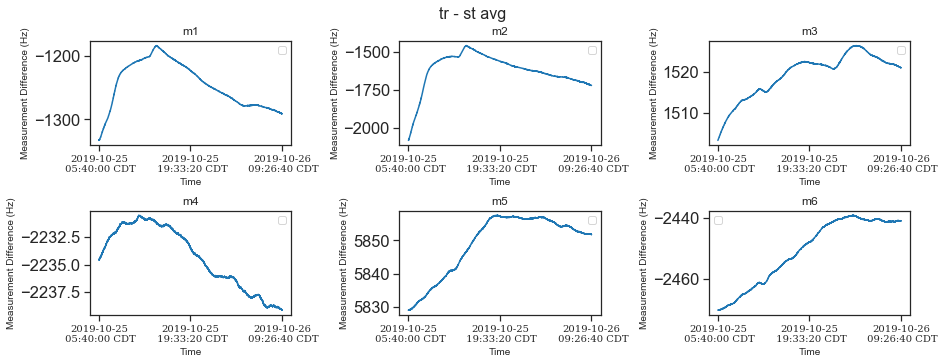

In [9]:
l1 = D1.min()            
h1 = D1.max()
l2 = D2.min()
h2 = D2.max()
l3 = D3.min()
h3 = D3.max()
l4 = D4.min()
h4 = D4.max()
l5 = D5.min()
h5 = D5.max()
l6 = D6.min()
h6 = D6.max()

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(T1 , D1)
#axs[0,0].plot(T1 , D1, '.')
#axs[0,0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r')
#axs[0].plot([T1[0] + 61200, T1[0] + 61200], [l1,h1], 'k', label = "cutoff")
axs[0,0].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time", fontsize = 10)
axs[0,0].set_xticks([T1[0], T1[len(T1)/2], T1[-1]])
axs[0,0].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,0].set_title('m1', fontsize = 12)

axs[0,1].plot(T2 , D2)
#axs[0,1].plot(T2 , D2, '.')
#axs[0,1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r')
#axs[1].plot([T2[0] + 61200, T2[0] + 61200], [l2,h2], 'k', label = "cutoff")
axs[0,1].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time", fontsize = 10)
axs[0,1].set_xticks([T2[0], T2[len(T2)/2], T2[-1]])
axs[0,1].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,1].set_title('m2', fontsize = 12)

axs[0,2].plot(T3 , D3)
#axs[0,2].plot(T3 , D3, '.')
#axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r')
#axs[0,2].plot([T3[0] + 61200, T3[0] + 61200], [l3,h3], 'k', label = "cutoff")
axs[0,2].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time", fontsize = 10)
axs[0,2].set_xticks([T3[0], T3[len(T3)/2], T3[-1]])
axs[0,2].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,2].set_title('m3', fontsize = 12)

axs[1,0].plot(T4 , D4)
#axs[1,0].plot(T4 , D4, '.')
#axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r')
#axs[1,0].plot([T4[0] + 61200, T4[0] + 61200], [l4,h4], 'k', label = "cutoff")
axs[1,0].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time", fontsize = 10)
axs[1,0].set_xticks([T4[0], T4[len(T4)/2], T4[-1]])
axs[1,0].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,0].set_title('m4', fontsize = 12)

axs[1,1].plot(T5 , D5)
#axs[1,1].plot(T5 , D5, '.')
#axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r')
#axs[1,1].plot([T5[0] + 61200, T5[0] + 61200], [l5,h5], 'k', label = "cutoff")
axs[1,1].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time", fontsize = 10)
axs[1,1].set_xticks([T5[0], T5[len(T5)/2], T5[-1]])
axs[1,1].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,1].set_title('m5', fontsize = 12)

axs[1,2].plot(T6 , D6)
#axs[1,2].plot(T6 , D6, '.')
#axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r')
#axs[1,2].plot([T6[0] + 61200, T6[0] + 61200], [l6,h6], 'k', label = "cutoff")
axs[1,2].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time", fontsize = 10)
axs[1,2].set_xticks([T6[0], T6[len(T6)/2], T6[-1]])
axs[1,2].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,2].set_title('m6', fontsize = 12)

fig.suptitle("tr - st avg" , fontsize = 16)
plt.show()


In [10]:
start1 = T1[0]
start2 = T2[0]
start3 = T3[0]
start4 = T4[0]
start5 = T5[0]
start6 = T6[0]

slopes1, intercepts1 = DayLineFit(T1, D1, start1)
slope_avg1 = np.average(slopes1)
intercept_avg1 = np.average(intercepts1)
print(slope_avg1)
print(intercept_avg1)
slopes1, intercepts1 = DayLineFit(T, y1, start1)
slope_avg1 = np.average(slopes1)
intercept_avg1 = np.average(intercepts1)
print(slope_avg1)
print(intercept_avg1)
print("*****************")

slopes2, intercepts2 = DayLineFit(T2, D2, start2)
slope_avg2 = np.average(slopes2)
intercept_avg2 = np.average(intercepts2)
print(slope_avg2)
print(intercept_avg2)
slopes2, intercepts2 = DayLineFit(T, y2, start2)
slope_avg2 = np.average(slopes2)
intercept_avg2 = np.average(intercepts2)
print(slope_avg2)
print(intercept_avg2)
print("*****************")

slopes3, intercepts3 = DayLineFit(T3, D3, start3)
slope_avg3 = np.average(slopes3)
intercept_avg3 = np.average(intercepts3)
print(slope_avg3)
print(intercept_avg3)
slopes3, intercepts3 = DayLineFit(T, y3, start3)
slope_avg3 = np.average(slopes3)
intercept_avg3 = np.average(intercepts3)
print(slope_avg3)
print(intercept_avg3)
print("*****************")

slopes4, intercepts4 = DayLineFit(T4, D4, start4)
slope_avg4 = np.average(slopes4)
intercept_avg4 = np.average(intercepts4)
print(slope_avg4)
print(intercept_avg4)
slopes4, intercepts4 = DayLineFit(T, y4, start4)
slope_avg4 = np.average(slopes4)
intercept_avg4 = np.average(intercepts4)
print(slope_avg4)
print(intercept_avg4)
print("*****************")


slopes5, intercepts5 = DayLineFit(T5, D5, start5)
slope_avg5 = np.average(slopes5)
intercept_avg5 = np.average(intercepts5)
print(slope_avg5)
print(intercept_avg5)
slopes5, intercepts5 = DayLineFit(T, y5, start5)
slope_avg5 = np.average(slopes5)
intercept_avg5 = np.average(intercepts5)
print(slope_avg5)
print(intercept_avg5)
print("*****************")

slopes6, intercepts6 = DayLineFit(T6, D6, start6)
slope_avg6 = np.average(slopes6)
intercept_avg6 = np.average(intercepts6)
print(slope_avg6)
print(intercept_avg6)
slopes6, intercepts6 = DayLineFit(T, y6, start6)
slope_avg6 = np.average(slopes6)
intercept_avg6 = np.average(intercepts6)
print(slope_avg6)
print(intercept_avg6)
print("*****************")

z1 = np.polyfit(T1, D1, 1)
z2 = np.polyfit(T2, D2, 1)
z3 = np.polyfit(T3, D3, 1)
z4 = np.polyfit(T4, D4, 1)
z5 = np.polyfit(T5, D5, 1)
z6 = np.polyfit(T6, D6, 1)

-0.0003945927012839715
619135.3548510405
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
-0.0004010641721598389
629309.3252786921
*****************
-0.00039019724381471555
611892.071860457
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
-0.0004296340261604798
673892.6243320134
*****************
7.665130713555391e-05
-118986.54223587336
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
7.388412064673911e-05
-114636.0729712614
*****************
-4.8829386999762283e-05
74533.90350307668
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
-4.898015220831516e-05
74770.91436702613
*****************
0.0001255835432181286
-191582.75814786536
The closest the value provided is exactly in between two elements of the array, the lowe

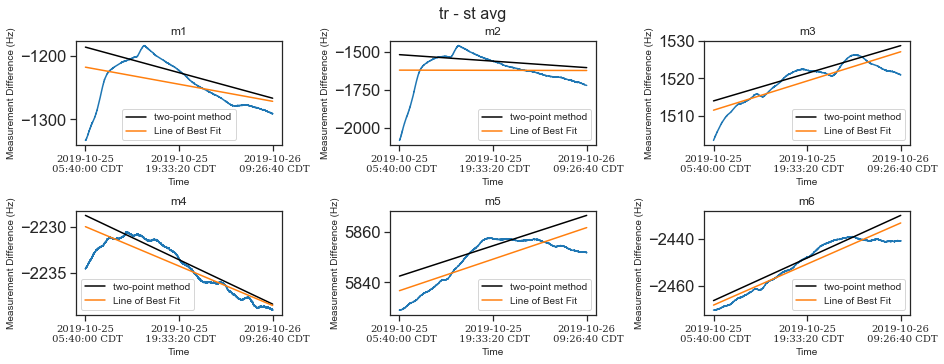

In [11]:
l1 = D1.min()            
h1 = D1.max()
l2 = D2.min()
h2 = D2.max()
l3 = D3.min()
h3 = D3.max()
l4 = D4.min()
h4 = D4.max()
l5 = D5.min()
h5 = D5.max()
l6 = D6.min()
h6 = D6.max()

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(T1 , D1)
#axs[0,0].plot(T1 , D1, '.')
axs[0,0].plot(T1, np.polyval([slope_avg1, intercept_avg1], T1), 'k', label = "two-point method")
axs[0,0].plot(T1, np.polyval(z1, T1), label = "Line of Best Fit")
#axs[0,0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r')
#axs[0].plot([T1[0] + 61200, T1[0] + 61200], [l1,h1], 'k', label = "cutoff")
axs[0,0].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time", fontsize = 10)
axs[0,0].set_xticks([T1[0], T1[len(T1)/2], T1[-1]])
axs[0,0].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,0].set_title('m1', fontsize = 12)

axs[0,1].plot(T2 , D2)
#axs[0,1].plot(T2 , D2, '.')
axs[0,1].plot(T2, np.polyval([slope_avg2, intercept_avg2], T2), 'k', label = "two-point method")
axs[0,1].plot(T2, np.polyval(z2, T2), label = "Line of Best Fit")
#axs[0,1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r')
#axs[1].plot([T2[0] + 61200, T2[0] + 61200], [l2,h2], 'k', label = "cutoff")
axs[0,1].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time", fontsize = 10)
axs[0,1].set_xticks([T2[0], T2[len(T2)/2], T2[-1]])
axs[0,1].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,1].set_title('m2', fontsize = 12)

axs[0,2].plot(T3 , D3)
#axs[0,2].plot(T3 , D3, '.')
axs[0,2].plot(T3, np.polyval([slope_avg3, intercept_avg3], T3), 'k', label = "two-point method")
axs[0,2].plot(T3, np.polyval(z3, T3), label = "Line of Best Fit")
#axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r')
#axs[0,2].plot([T3[0] + 61200, T3[0] + 61200], [l3,h3], 'k', label = "cutoff")
axs[0,2].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time", fontsize = 10)
axs[0,2].set_xticks([T3[0], T3[len(T3)/2], T3[-1]])
axs[0,2].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,2].set_title('m3', fontsize = 12)

axs[1,0].plot(T4 , D4)
#axs[1,0].plot(T4 , D4, '.')
axs[1,0].plot(T4, np.polyval([slope_avg4, intercept_avg4], T4), 'k', label = "two-point method")
axs[1,0].plot(T4, np.polyval(z4, T4), label = "Line of Best Fit")
#axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r')
#axs[1,0].plot([T4[0] + 61200, T4[0] + 61200], [l4,h4], 'k', label = "cutoff")
axs[1,0].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time", fontsize = 10)
axs[1,0].set_xticks([T4[0], T4[len(T4)/2], T4[-1]])
axs[1,0].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,0].set_title('m4', fontsize = 12)

axs[1,1].plot(T5 , D5)
#axs[1,1].plot(T5 , D5, '.')
axs[1,1].plot(T5, np.polyval([slope_avg5, intercept_avg5], T5), 'k', label = "two-point method")
axs[1,1].plot(T5, np.polyval(z5, T5), label = "Line of Best Fit")
#axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r')
#axs[1,1].plot([T5[0] + 61200, T5[0] + 61200], [l5,h5], 'k', label = "cutoff")
axs[1,1].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time", fontsize = 10)
axs[1,1].set_xticks([T5[0], T5[len(T5)/2], T5[-1]])
axs[1,1].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,1].set_title('m5', fontsize = 12)

axs[1,2].plot(T6 , D6)
#axs[1,2].plot(T6 , D6, '.')
axs[1,2].plot(T6, np.polyval([slope_avg6, intercept_avg6], T6), 'k', label = "two-point method")
axs[1,2].plot(T6, np.polyval(z6, T6), label = "Line of Best Fit")
#axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r')
#axs[1,2].plot([T6[0] + 61200, T6[0] + 61200], [l6,h6], 'k', label = "cutoff")
axs[1,2].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time", fontsize = 10)
axs[1,2].set_xticks([T6[0], T6[len(T6)/2], T6[-1]])
axs[1,2].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,2].set_title('m6', fontsize = 12)

fig.suptitle("tr - st avg", fontsize = 16)
plt.show()

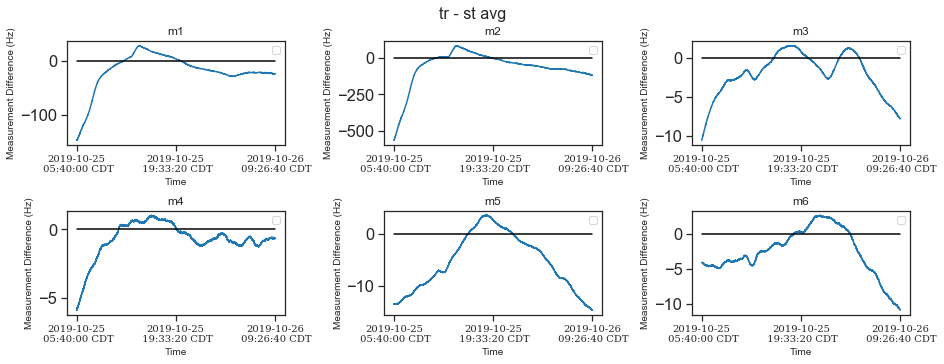

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [12]:
l1 = np.min(D1 - np.polyval([slope_avg1, intercept_avg1], T1))            
h1 = np.max(D1 - np.polyval([slope_avg1, intercept_avg1], T1))
l2 = np.min(D2 - np.polyval([slope_avg2, intercept_avg2], T2))
h2 = np.max(D2 - np.polyval([slope_avg2, intercept_avg2], T2))
l3 = np.min(D3 - np.polyval([slope_avg3, intercept_avg3], T3))
h3 = np.max(D3 - np.polyval([slope_avg3, intercept_avg3], T3))
l4 = np.min(D4 - np.polyval([slope_avg4, intercept_avg4], T4))
h4 = np.max(D4 - np.polyval([slope_avg4, intercept_avg4], T4))
l5 = np.min(D5 - np.polyval([slope_avg5, intercept_avg5], T5))
h5 = np.max(D5 - np.polyval([slope_avg5, intercept_avg5], T5))
l6 = np.min(D6 - np.polyval([slope_avg6, intercept_avg6], T6))
h6 = np.max(D6 - np.polyval([slope_avg6, intercept_avg6], T6))

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(T1 , D1-np.polyval([slope_avg1, intercept_avg1], T1))
#axs[0,0].plot(day + run_start + 10000, [l1,h1], 'r', 2*day + run_start + 10000, [l1,h1], 'r')
#axs[0,0].plot([500,500] + T1[0], [l1,h1])
axs[0,0].plot([T1.min(), T1.max()], [0,0], 'k')
axs[0,0].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time", fontsize = 10)
axs[0,0].set_xticks([T1[0], T1[len(T1)/2], T1[-1]])
axs[0,0].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,0].set_title('m1', fontsize = 12)
#axs[0,0].legend(fontsize = 12)

axs[0,1].plot(T2 , D2-np.polyval([slope_avg2, intercept_avg2], T2))
#axs[0,1].plot(day + run_start + 10000, [l2,h2], 'r', 2*day + run_start + 10000, [l2,h2], 'r')
#axs[0,1].plot([500,500] + T2[0], [l2,h2])
axs[0,1].plot([T2.min(), T2.max()], [0,0], 'k')
axs[0,1].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time", fontsize = 10)
axs[0,1].set_xticks([T2[0], T2[len(T2)/2], T2[-1]])
axs[0,1].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,1].set_title('m2', fontsize = 12)
#axs[0,1].legend(fontsize = 12)

axs[0,2].plot(T3 , D3-np.polyval([slope_avg3, intercept_avg3], T3))
#axs[0,2].plot(day + run_start + 10000, [l3,h3], 'r', 2*day + run_start + 10000, [l3,h3], 'r')
#axs[0,2].plot([500,500] + T3[0], [l3,h3])
axs[0,2].plot([T3.min(), T3.max()], [0,0], 'k')
axs[0,2].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time", fontsize = 10)
axs[0,2].set_xticks([T3[0], T3[len(T3)/2], T3[-1]])
axs[0,2].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,2].set_title('m3', fontsize = 12)
#axs[0,2].legend(fontsize = 12)

axs[1,0].plot(T4 , D4-np.polyval([slope_avg4, intercept_avg4], T4))
#axs[1,0].plot(day + run_start + 10000, [l4,h4], 'r', 2*day + run_start + 10000, [l4,h4], 'r')
#axs[1,0].plot([500,500] + T4[0], [l4,h4])
axs[1,0].plot([T4.min(), T4.max()], [0,0], 'k')
axs[1,0].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time", fontsize = 10)
axs[1,0].set_xticks([T4[0], T4[len(T4)/2], T4[-1]])
axs[1,0].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,0].set_title('m4', fontsize = 12)
#axs[1,0].legend(fontsize = 12)

axs[1,1].plot(T5 , D5-np.polyval([slope_avg5, intercept_avg5], T5))
#axs[1,1].plot(day + run_start + 10000, [l5,h5], 'r', 2*day + run_start + 10000, [l5,h5], 'r')
#axs[1,1].plot([500,500] + T5[0], [l5,h5])
axs[1,1].plot([T5.min(), T5.max()], [0,0], 'k')
axs[1,1].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time", fontsize = 10)
axs[1,1].set_xticks([T5[0], T5[len(T5)/2], T5[-1]])
axs[1,1].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,1].set_title('m5', fontsize = 12)
#axs[1,1].legend(fontsize = 12)

axs[1,2].plot(T6 , D6-np.polyval([slope_avg6, intercept_avg6], T6))
#axs[1,2].plot(day + run_start + 10000, [l6,h6], 'r', 2*day + run_start + 10000, [l6,h6], 'r')
#axs[1,2].plot([500,500] + T6[0], [l6,h6])
axs[1,2].plot([T6.min(), T6.max()], [0,0], 'k')
axs[1,2].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time", fontsize = 10)
axs[1,2].set_xticks([T6[0], T6[len(T6)/2], T6[-1]])
axs[1,2].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,2].set_title('m6', fontsize = 12)
#axs[1,2].legend(fontsize = 12)

fig.suptitle("tr - st avg", fontsize = 16)
plt.show()
###############################################################################################
#Bounds are chosen to be the max deviation from y = 0
corr_diff1 = y1 - np.polyval([slope_avg1, intercept_avg1], T)
vars1, cov1 = curve_fit(cos, T, corr_diff1, bounds = ([3,0],[5, 86400]))
print(vars1)

corr_diff2 = y2 - np.polyval([slope_avg2, intercept_avg2], T)
vars2, cov2 = curve_fit(cos, T, corr_diff2, bounds = ([1,0],[3, 86400]))
print(vars2)

corr_diff3 = y3 - np.polyval([slope_avg3, intercept_avg3], T)
vars3, cov3 = curve_fit(cos, T, corr_diff3, bounds = ([-max([abs(l3), h3]),0],[max([abs(l3), h3]), 86400]))
print(vars3)

corr_diff4 = y4 - np.polyval([slope_avg4, intercept_avg4], T)
vars4, cov4 = curve_fit(cos, T, corr_diff4, bounds = ([-max([abs(l4), h4]),0],[max([abs(l4), h4]), 86400]))
print(vars4)


corr_diff5 = y5 - np.polyval([slope_avg5, intercept_avg5], T)
vars5, cov5 = curve_fit(cos, T, corr_diff5, bounds = ([-max([abs(l5), h5]),0],[max([abs(l5), h5]), 2 * np.pi]))
print(vars5)

corr_diff6 = y6 - np.polyval([slope_avg6, intercept_avg6], T)
vars6, cov6 = curve_fit(cos, T, corr_diff6, bounds = ([-max([abs(l6), h6]),0],[max([abs(l6), h6]), 2 * np.pi]))
print(vars6)

A1 = vars1[0]
phi1 = vars1[1]

A2 = vars2[0]
phi2 = vars2[1]

A3 = vars3[0]
phi3 = vars3[1]

A4 = vars4[0]
phi4 = vars4[1]

A5 = vars5[0]
phi5 = vars5[1]

A6 = vars6[0]
phi6 = vars6[1]

In [ ]:
l1 = np.min(D1 - np.polyval([slope_avg1, intercept_avg1], T1))            
h1 = np.max(D1 - np.polyval([slope_avg1, intercept_avg1], T1))
l2 = np.min(D2 - np.polyval([slope_avg2, intercept_avg2], T2))
h2 = np.max(D2 - np.polyval([slope_avg2, intercept_avg2], T2))
l3 = np.min(D3 - np.polyval([slope_avg3, intercept_avg3], T3))
h3 = np.max(D3 - np.polyval([slope_avg3, intercept_avg3], T3))
l4 = np.min(D4 - np.polyval([slope_avg4, intercept_avg4], T4))
h4 = np.max(D4 - np.polyval([slope_avg4, intercept_avg4], T4))
l5 = np.min(D5 - np.polyval([slope_avg5, intercept_avg5], T5))
h5 = np.max(D5 - np.polyval([slope_avg5, intercept_avg5], T5))
l6 = np.min(D6 - np.polyval([slope_avg6, intercept_avg6], T6))
h6 = np.max(D6 - np.polyval([slope_avg6, intercept_avg6], T6))

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(T1 , D1-np.polyval([slope_avg1, intercept_avg1], T1))
#axs[0,0].plot(day + run_start + 10000, [l1,h1], 'r', 2*day + run_start + 10000, [l1,h1], 'r')
axs[0,0].plot(T1, cos(T1, A1, phi1))
#axs[0,0].plot([500,500] + T1[0], [l1,h1])
axs[0,0].plot([T1.min(), T1.max()], [0,0], 'k')
axs[0,0].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time", fontsize = 10)
axs[0,0].set_xticks([T1[0], T1[len(T1)/2], T1[-1]])
axs[0,0].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,0].set_title('m1', fontsize = 12)
#axs[0,0].legend(fontsize = 12)

axs[0,1].plot(T2 , D2-np.polyval([slope_avg2, intercept_avg2], T2))
#axs[0,1].plot(day + run_start + 10000, [l2,h2], 'r', 2*day + run_start + 10000, [l2,h2], 'r')
axs[0,1].plot(T2, cos(T2, A2, phi2))
#axs[0,1].plot([500,500] + T2[0], [l2,h2])
axs[0,1].plot([T2.min(), T2.max()], [0,0], 'k')
axs[0,1].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time", fontsize = 10)
axs[0,1].set_xticks([T2[0], T2[len(T2)/2], T2[-1]])
axs[0,1].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,1].set_title('m2', fontsize = 12)
#axs[0,1].legend(fontsize = 12)

axs[0,2].plot(T3 , D3-np.polyval([slope_avg3, intercept_avg3], T3))
#axs[0,2].plot(day + run_start + 10000, [l3,h3], 'r', 2*day + run_start + 10000, [l3,h3], 'r')
axs[0,2].plot(T3, cos(T3, A3, phi3))
#axs[0,2].plot([500,500] + T3[0], [l3,h3])
axs[0,2].plot([T3.min(), T3.max()], [0,0], 'k')
axs[0,2].legend(fontsize = 10)
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time", fontsize = 10)
axs[0,2].set_xticks([T3[0], T3[len(T3)/2], T3[-1]])
axs[0,2].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[0,2].set_title('m3', fontsize = 12)
#axs[0,2].legend(fontsize = 12)

axs[1,0].plot(T4 , D4-np.polyval([slope_avg4, intercept_avg4], T4))
#axs[1,0].plot(day + run_start + 10000, [l4,h4], 'r', 2*day + run_start + 10000, [l4,h4], 'r')
axs[1,0].plot(T4, cos(T4, A4, phi4))
#axs[1,0].plot([500,500] + T4[0], [l4,h4])
axs[1,0].plot([T4.min(), T4.max()], [0,0], 'k')
axs[1,0].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time", fontsize = 10)
axs[1,0].set_xticks([T4[0], T4[len(T4)/2], T4[-1]])
axs[1,0].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,0].set_title('m4', fontsize = 12)
#axs[1,0].legend(fontsize = 12)

axs[1,1].plot(T5 , D5-np.polyval([slope_avg5, intercept_avg5], T5))
#axs[1,1].plot(day + run_start + 10000, [l5,h5], 'r', 2*day + run_start + 10000, [l5,h5], 'r')
axs[1,1].plot(T5, cos(T5, A5, phi5))
#axs[1,1].plot([500,500] + T5[0], [l5,h5])
axs[1,1].plot([T5.min(), T5.max()], [0,0], 'k')
axs[1,1].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time", fontsize = 10)
axs[1,1].set_xticks([T5[0], T5[len(T5)/2], T5[-1]])
axs[1,1].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,1].set_title('m5', fontsize = 12)
#axs[1,1].legend(fontsize = 12)

axs[1,2].plot(T6 , D6-np.polyval([slope_avg6, intercept_avg6], T6))
#axs[1,2].plot(day + run_start + 10000, [l6,h6], 'r', 2*day + run_start + 10000, [l6,h6], 'r')
axs[1,2].plot(T6, cos(T6, A6, phi6))
#axs[1,2].plot([500,500] + T6[0], [l6,h6])
axs[1,2].plot([T6.min(), T6.max()], [0,0], 'k')
axs[1,2].legend(fontsize = 10)
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time", fontsize = 10)
axs[1,2].set_xticks([T6[0], T6[len(T6)/2], T6[-1]])
axs[1,2].set_ylabel("Measurement Difference (Hz)", fontsize = 10)
axs[1,2].set_title('m6', fontsize = 12)
#axs[1,2].legend(fontsize = 12)

fig.suptitle("tr - st avg", fontsize = 16)
plt.show()

In [ ]:
print("The phase difference is " + str(86400*(phi1- phi2)/(2 * np.pi)) + " seconds")

In [ ]:
t = np.logspace(0, math.log(len(stAm1_list),10), 50)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data

#Computing the Allan Deviations of the differences:
(tb1, adb1, ade, adn) = allantools.oadev(y1, rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(tb2, adb2, ade, adn) = allantools.oadev(y2, rate=r, data_type="freq", taus = t)
(tb3, adb3, ade, adn) = allantools.oadev(y3, rate=r, data_type="freq", taus = t)  
(tb4, adb4, ade, adn) = allantools.oadev(y4, rate=r, data_type="freq", taus = t)
(tb5, adb5, ade, adn) = allantools.oadev(y5, rate=r, data_type="freq", taus = t) 
(tb6, adb6, ade, adn) = allantools.oadev(y6, rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgtb1 = tb1[np.where(adb1==adb1.min())][0]
avgtb2 = tb2[np.where(adb2==adb2.min())][0]
avgtb3 = tb3[np.where(adb3==adb3.min())][0]
avgtb4 = tb4[np.where(adb4==adb4.min())][0]
avgtb5 = tb5[np.where(adb5==adb5.min())][0]
avgtb6 = tb6[np.where(adb6==adb6.min())][0]

In [ ]:
run_start = T[0]
T = sl_moment_df.index.to_numpy() - (run_start + 61200)
t = np.logspace(0, math.log(len(stAm1_list),10), num = 200)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data
#Computing Allan Deviations of the differences:
(t1, ad1, ade, adn) = allantools.oadev(corr_diff1, rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(t2, ad2, ade, adn) = allantools.oadev(corr_diff2, rate=r, data_type="freq", taus = t)
(t3, ad3, ade, adn) = allantools.oadev(corr_diff3, rate=r, data_type="freq", taus = t)  
(t4, ad4, ade, adn) = allantools.oadev(corr_diff4, rate=r, data_type="freq", taus = t)
(t5, ad5, ade, adn) = allantools.oadev(corr_diff5, rate=r, data_type="freq", taus = t) 
(t6, ad6, ade, adn) = allantools.oadev(corr_diff6, rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgt1 = t1[np.where(ad1==ad1.min())][0]
avgt2 = t2[np.where(ad2==ad2.min())][0]
avgt3 = t3[np.where(ad3==ad3.min())][0]
avgt4 = t4[np.where(ad4==ad4.min())][0]
avgt5 = t5[np.where(ad5==ad5.min())][0]
avgt6 = t6[np.where(ad6==ad6.min())][0]

#Plots Allan Deviation
day  = np.array([86400, 86400])
ad1m = np.array([min(ad1), max(ad1)])
ad2m = np.array([min(ad2), max(ad2)])
ad3m = np.array([min(ad3), max(ad3)])
ad4m = np.array([min(ad4), max(ad4)])
ad5m = np.array([min(ad5), max(ad5)])
ad6m = np.array([min(ad6), max(ad6)])

l1 = np.min(ad1)            
h1 = np.max(ad1)
l2 = np.min(ad2)
h2 = np.max(ad2)
l3 = np.min(ad3)
h3 = np.max(ad3)
l4 = np.min(ad4)
h4 = np.max(ad4)
l5 = np.min(ad5)
h5 = np.max(ad5)
l6 = np.min(ad6)
h6 = np.max(ad6)

fig, axs = plt.subplots(2, 3, constrained_layout=True) #This is St22 vs Trolley
fig.set_figheight(8)
fig.set_figwidth(13)

axs[0,0].plot(t1, ad1, label = "After corrections")
axs[0,0].plot(tb1, adb1, 'c', label = "before drift removal")
axs[0,0].plot([86400,86400],[.01,3], 'r')
axs[0,0].set_xscale('log')
axs[0,0].set_ylim(0.05, 40)                                                                          
axs[0,0].set_yscale('log')
axs[0,0].legend()
axs[0,0].set_xlabel("Time in s")
axs[0,0].set_ylabel("Allan Deviation")
axs[0,0].set_title('m1')

axs[0,1].plot(t2,ad2, label = "After corrections")
axs[0,1].plot(tb2,adb2, 'c', label = "before drift removal")
axs[0,1].plot([86400,86400],[.01,3], 'r')
axs[0,1].set_ylim(0.05,40)                                                                          
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].legend()
axs[0,1].set_xlabel("Time in s")
axs[0,1].set_ylabel("Allan Deviation")
axs[0,1].set_title('m2')

axs[0,2].plot(t3,ad3, label = "After corrections")
axs[0,2].plot(tb3,adb3, 'c', label = "before drift removal")
axs[0,2].plot([86400,86400],[.01,3], 'r')
axs[0,2].set_ylim(0.05,40)                                                                          
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].legend()
axs[0,2].set_xlabel("Time in s")
axs[0,2].set_ylabel("Allan Deviation")
axs[0,2].set_title('m3')

axs[1,0].plot(t4,ad4, label = "After corrections")
axs[1,0].plot(tb4,adb4, 'c', label = "before drift removal")
axs[1,0].plot([86400,86400],[.01,3], 'r')
axs[1,0].set_ylim(0.05,40)                                                                          
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].legend()
axs[1,0].set_xlabel("Time in s")
axs[1,0].set_ylabel("Allan Deviation")
axs[1,0].set_title('m4')

axs[1,1].plot(t5,ad5, label = "After corrections")
axs[1,1].plot(tb5,adb5, 'c', label = "before drift removal")
axs[1,1].plot([86400,86400],[.01,3], 'r')
axs[1,1].set_ylim(0.05,40)                                                                          
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].legend()
axs[1,1].set_xlabel("Time in s")
axs[1,1].set_ylabel("Allan Deviation")
axs[1,1].set_title('m5')

axs[1,2].plot(t6,ad6, label = "After corrections")
axs[1,2].plot(tb6,adb6, 'c', label = "before drift removal")
axs[1,2].plot([86400,86400],[.01,3], 'r')
axs[1,2].set_ylim(0.05,40)                                                                          
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')
axs[1,2].legend()
axs[1,2].set_xlabel("Time in s")
axs[1,2].set_ylabel("Allan Deviation")
axs[1,2].set_title('m6')

fig.suptitle("tr - station average")

plt.show()